### Predicción de Afluencia en el Metro de la Ciudad de México

Este proyecto tiene como objetivo predecir la afluencia diaria de pasajeros por estación en el Metro de la CDMX, utilizando datos históricos de 2021 a 2025.

La motivación es responder preguntas como:

- ¿Qué tan lleno estará el metro en una fecha y estación determinada?
- ¿Podemos anticipar patrones que superen métodos simples como repetir el valor de la semana pasada?

## Datos
Fuente: Registros de afluencia del STC Metro CDMX (2021–2025).
Nivel temporal: diario por estación.
Variables: fecha, estación, línea, afluencia total, tipo de pago (descartado en el modelado).
Features creadas: día de la semana, fin de semana, ID único de estación.

## Resultados
- LSTM: MAPE ≈ 17% en validación.
- Baselines: MAPE 18–19%.
- El modelo supera los baselines, especialmente en estaciones grandes (MAPE ~9%).
- Peor desempeño en estaciones con alta volatilidad (ej. Zócalo/Tenochtitlan, Tláhuac).

In [30]:
#importar librería

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, GRU, Input, Embedding, Flatten, Concatenate
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from collections import defaultdict

In [3]:
#leer datos

afluencia = pd.read_csv('afluencia.csv')

#mostrar info

print(afluencia.info())

#mostrar primeras filas

print(afluencia.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 943020 entries, 0 to 943019
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   fecha      943020 non-null  object
 1   mes        943020 non-null  object
 2   anio       943020 non-null  int64 
 3   linea      943020 non-null  object
 4   estacion   943020 non-null  object
 5   tipo_pago  943020 non-null  object
 6   afluencia  943020 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 50.4+ MB
None
        fecha    mes  anio     linea                 estacion  tipo_pago  \
0  2021-01-01  Enero  2021  LÃ­nea 1                 Balbuena     Boleto   
1  2021-01-01  Enero  2021  LÃ­nea 1                 Balbuena    Prepago   
2  2021-01-01  Enero  2021  LÃ­nea 1                 Balbuena  Gratuidad   
3  2021-01-01  Enero  2021  LÃ­nea 1                 Balderas     Boleto   
4  2021-01-01  Enero  2021  LÃ­nea 1                 Balderas    Prepago   
5  2021-01-01  Ene

In [4]:
for i in afluencia.columns:
    unique_values = afluencia[i].unique()
    print(unique_values)

['2021-01-01' '2021-01-02' '2021-01-03' ... '2025-05-29' '2025-05-30'
 '2025-05-31']
['Enero' 'Febrero' 'Marzo' 'Abril' 'Mayo' 'Junio' 'Julio' 'Agosto'
 'Septiembre' 'Octubre' 'Noviembre' 'Diciembre']
[2021 2022 2023 2024 2025]
['LÃ\xadnea 1' 'LÃ\xadnea 12' 'LÃ\xadnea 2' 'LÃ\xadnea 3' 'LÃ\xadnea 4'
 'LÃ\xadnea 5' 'LÃ\xadnea 6' 'LÃ\xadnea 7' 'LÃ\xadnea 8' 'LÃ\xadnea 9'
 'LÃ\xadnea A' 'LÃ\xadnea B' 'Linea 1' 'Linea 2' 'Linea 3' 'Linea 4'
 'Linea 5' 'Linea 6' 'Linea 7' 'Linea 8' 'Linea 9' 'Linea A' 'Linea B'
 'Linea 12']
['Balbuena' 'Balderas' 'Boulevard Puerto AÃ©reo' 'Candelaria'
 'Chapultepec' 'CuauhtÃ©moc' 'GÃ³mez FarÃ\xadas' 'Insurgentes'
 'Isabel la CatÃ³lica' 'JuanacatlÃ¡n' 'Merced' 'Moctezuma' 'Observatorio'
 'PantitlÃ¡n' 'Pino SuÃ¡rez' 'Salto del Agua' 'San LÃ¡zaro' 'Sevilla'
 'Tacubaya' 'Zaragoza' 'Hospital 20 de Noviembre' 'Atlalilco' 'Calle 11'
 'CulhuacÃ¡n' 'Eje Central' 'Ermita' 'Insurgentes Sur' 'Lomas Estrella'
 'Mexicaltzingo' 'Mixcoac' 'Nopalera' 'Olivos' 'Parque de los 

In [32]:
#definir diccionario para reemplazos

replacements = { 'LÃ\xadnea 1': 'Línea 1', 'LÃ\xadnea 2': 'Línea 2', 'LÃ\xadnea 3': 'Línea 3', 'LÃ\xadnea 4': 'Línea 4', 'LÃ\xadnea 5': 'Línea 5',
                'LÃ\xadnea 6': 'Línea 6', 'LÃ\xadnea 7': 'Línea 7', 'LÃ\xadnea 8': 'Línea 8', 'LÃ\xadnea 9': 'Línea 9', 'LÃ\xadnea A': 'Línea A',
                'LÃ\xadnea B': 'Línea B', 'LÃ\xadnea 12': 'Línea 12', 'ZapotitlÃ¡n': 'Zapotitlán',
                'Linea 1': 'Línea 1', 'Linea 2': 'Línea 2', 'Linea 3': 'Línea 3', 'Linea 4': 'Línea 4', 'Linea 5': 'Línea 5',
                'Linea 6': 'Línea 6', 'Linea 7': 'Línea 7', 'Linea 8': 'Línea 8', 'Linea 9': 'Línea 9', 'Linea A': 'Línea A','Linea 12': 'Línea 12',
                'Linea': 'Línea','CuauhtÃ©moc': 'Cuauhtémoc','GÃ³mez FarÃ\xadas': 'Gómez Farías','Isabel la CatÃ³lica': 'Isabel la Católica',
                'NiÃ±os HÃ©roes': 'Niños Héroes','JuanacatlÃ¡n': 'Juanacatlán','San Ã\x81ngel': 'San Ángel','CulhuacÃ¡n': 'Culhuacán',
                'PantitlÃ¡n': 'Pantitlán','TÃ©llez': 'Tláhuac','TÃ©cotl': 'Tepalcates','Pino SuÃ¡rez': 'Pino Suárez','San LÃ¡zaro': 'San Lázaro',
                'PerifÃ©rico Oriente': 'Periférico Oriente', 'PerifÃ©rico Sur': 'Periférico Sur','San AndrÃ©s TomatlÃ¡n': 'San Andrés Tomatlán',
                'ConstituciÃ³n de 1917': 'Constitución de 1917','NezahualcÃ³yotl': 'Nezahualcóyotl','TlÃ¡huac': 'Tláhuac','CuitlÃ¡huac': 'Cuitláhuac',
                'RevoluciÃ³n': 'Revolución','TasqueÃ±a': 'Tasqueña','Villa de CortÃ©s': 'Villa de Cortés','ZÃ³calo/Tenochtitlan': 'Zócalo/Tenochtitlan',
                'Centro MÃ©dico': 'Centro Médico','CoyoacÃ¡n': 'Coyoacán','DivisiÃ³n del Norte': 'División del Norte',
                'EtiopÃ\xada/Plaza de la Transparencia': 'Etiopía/Plaza de la Transparencia','PeÃ±Ã³n viejo': 'Peñón viejo',
                'Miguel Ã\x81ngel de Quevedo': 'Miguel Ángel de Quevedo', 'Instituto del PetrÃ³leo': 'Instituto del Petróleo',
                'Valle GÃ³mez': 'Valle Gómez', 'RÃ\xado de los Remedios': 'Río de los Remedios', 'JuÃ¡rez': 'Juárez',
                'NiÃ±os HÃ©roes': 'Niños Héroes', 'GÃ³mez Farias': 'Gómez Farías', 'Villa de AragÃ³n': 'Villa de Aragón',
                'PeÃ±Ã³n Viejo': 'Peñón Viejo', 'Peñón viejo':'Peñón Viejo','OlÃ­mpica': 'Olímpica', 'PolitÃ©cnico ': 'Politécnico',
                'Terminal AÃ©rea': 'Terminal Aérea', 'MartÃ­n Carrera':'Martín Carrera', 'Bosque de AragÃ³n':'Bosque de Aragón',
                'OceanÃ­a':'Oceanía', 'Deportivo OceanÃ­a':'Deportivo Oceanía', 'AgrÃ­cola Oriental':'Agrícola Oriental', 
                'Boulevard Puerto AÃ©reo':'Boulevard Puerto Aéreo', 'Ricardo Flores MagÃ³n':'Ricardo Flores Magón',
                'San JoaquÃ\xadn':'San Joaquín', 'AragÃ³n':'Aragón', 'MÃºzquiz':'Múzquiz', 'Plaza AragÃ³n':'Plaza Aragón'}

# Columnas a limpiar
columnas_a_limpiar = ['estacion', 'linea']

# Aplicar los reemplazos en las columnas especificadas
for col in columnas_a_limpiar:
    if col in afluencia.columns:
        
        afluencia[col] = afluencia[col].astype(str) 
        for error, correccion in replacements.items():
            afluencia[col] = afluencia[col].str.replace(error, correccion, regex=False)

In [33]:
#convertir columna fecha a datetime

afluencia['fecha'] = pd.to_datetime(afluencia['fecha'])

afluencia['dia_semana'] = afluencia['fecha'].dt.day_name()

#comprobar cambios
print(afluencia['fecha'].info())

print(afluencia['dia_semana'].head())

<class 'pandas.core.series.Series'>
RangeIndex: 943020 entries, 0 to 943019
Series name: fecha
Non-Null Count   Dtype         
--------------   -----         
943020 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 7.2 MB
None
0    Friday
1    Friday
2    Friday
3    Friday
4    Friday
Name: dia_semana, dtype: object


## EDA

En el siguiente EDA se busca entender los patrones de las estaciones, buscar aquellas con mayor afluencia y aquellas cuyo flujo es mas bien constante. De igual manera, se incluye un clustering para agrupar las estaciones por su comportamiento, independientemente de su afluencia.

<Axes: xlabel='estacion'>

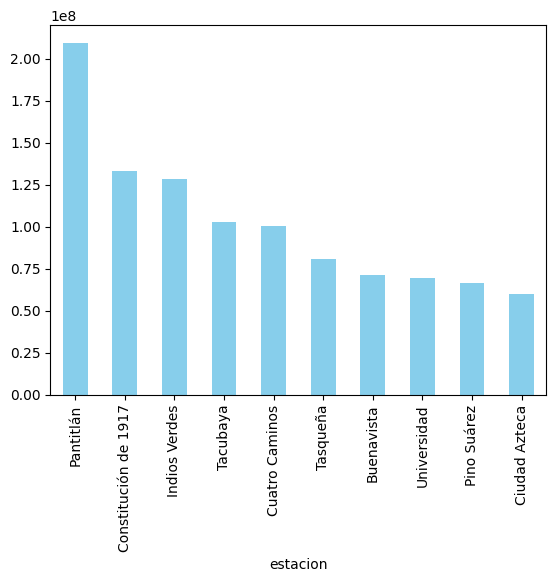

In [7]:
#agrupar el top 10 de estacion es con mayor afluencia
top_10 = afluencia.groupby('estacion')['afluencia'].sum().nlargest(10)

#graficar el top 10
top_10.plot(kind='bar', color='skyblue')

<Axes: xlabel='dia_semana,estacion'>

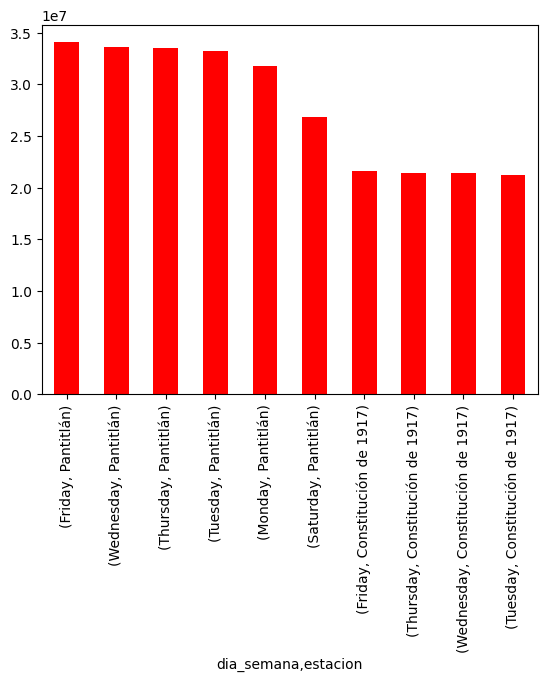

In [8]:
#agrupar el top 10 de dias con mayor afluencia

top_10_dia = afluencia.groupby(['dia_semana', 'estacion'])['afluencia'].sum().nlargest(10)

#graficar el top 10 de dias

top_10_dia.plot(kind='bar', color='red')

<Axes: xlabel='dia_semana'>

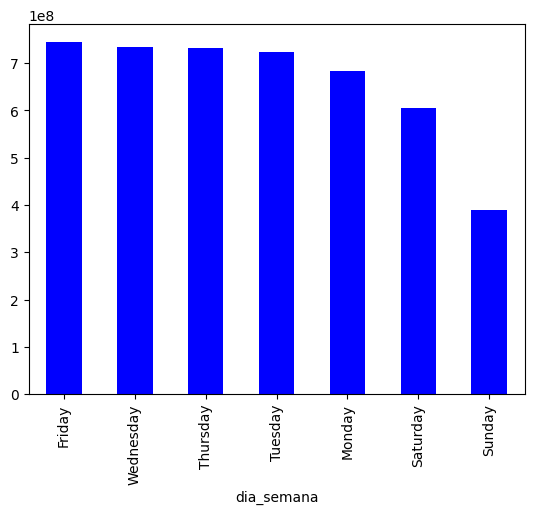

In [9]:
#top con mayor afleuncia por dia de la semana
top_dia_total = afluencia.groupby('dia_semana')['afluencia'].sum().nlargest(10)

top_dia_total.plot(kind='bar', color='blue')

In [10]:
pivot_estaciones = pd.pivot_table(afluencia, values='afluencia', index='estacion', columns='dia_semana')

print(pivot_estaciones)

dia_semana                 Friday        Monday      Saturday       Sunday  \
estacion                                                                     
Acatitla              4749.548341   4473.013043   4121.561328  2981.447826   
Aculco                2952.712843   2660.640580   2280.135642  1383.933333   
Agrícola Oriental     3609.617605   3243.376812   3136.323232  1999.969565   
Allende               7081.209235   6079.262319   8101.200577  4399.149275   
Apatlaco              3803.088023   3459.705797   3369.344877  2708.121739   
...                           ...           ...           ...          ...   
Xola                  5583.252525   5006.047826   4428.769120  2490.792754   
Zapata                5234.695527   4633.308696   3873.482684  2380.900725   
Zapotitlán            1485.233766   1379.824638   1157.181818   853.118841   
Zaragoza              5999.997114   5838.113043   5116.995671  3318.439130   
Zócalo/Tenochtitlan  12307.089466  11121.798551  13145.059163  8

In [34]:
#crear un escalador MinMax

scaler = MinMaxScaler()

#escalar pivot_estaciones

pivot_estaciones_scaled = scaler.fit_transform(pivot_estaciones)

#transformar a dataframe

pivot_df = pd.DataFrame(pivot_estaciones_scaled, index=pivot_estaciones.index, columns=pivot_estaciones.columns)

#aplicar kmeans

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(pivot_df)

,n_clusters,3
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,42
,copy_x,True
,algorithm,'lloyd'


In [35]:
#añadir las etiquetas

pivot_df['Cluster'] = kmeans.labels_

#contar los clusters

print(pivot_df['Cluster'].value_counts())

#ver los centroides

print(kmeans.cluster_centers_)

Cluster
2    94
0    63
1     6
Name: count, dtype: int64
[[0.22818735 0.22654784 0.23332979 0.22007334 0.22632482 0.22436253
  0.22758581]
 [0.72623168 0.72748941 0.7420717  0.69031389 0.71607031 0.71642682
  0.71688835]
 [0.08628365 0.0845822  0.08543683 0.0806587  0.086087   0.08598533
  0.08669513]]


In [36]:
#filtrar y mostrar el cluster 1

cluster_1 = pivot_df[pivot_df['Cluster'] == 1]

cluster_1

dia_semana,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Cluster
estacion,,,,,,,,
Buenavista,0.518426,0.513288,0.574856,0.535772,0.512306,0.502619,0.516890,1
Constitución de 1917,1.000000,1.000000,1.000000,0.912128,1.000000,1.000000,1.000000,1
Cuatro Caminos,0.757108,0.747556,0.792777,0.692326,0.737885,0.739104,0.740736,1
Indios Verdes,0.945746,0.976257,0.995458,1.000000,0.929814,0.934118,0.932435,1
Tasqueña,0.590642,0.608472,0.647154,0.618190,0.577164,0.583050,0.575965,1
Universidad,0.545469,0.519364,0.442185,0.383468,0.539253,0.539670,0.535303,1


In [37]:
#filtrar y mostrar el cluster 0

cluster_0 = pivot_df[pivot_df['Cluster'] == 0]

cluster_0

dia_semana,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Cluster
estacion,,,,,,,,
Allende,0.213982,0.196449,0.316501,0.249590,0.205725,0.198308,0.203203,0
Auditorio,0.306840,0.279553,0.249344,0.237156,0.303662,0.300468,0.307524,0
Autobuses del Norte,0.174030,0.209442,0.212957,0.295037,0.158358,0.169342,0.159171,0
Balderas,0.158263,0.160742,0.156547,0.144334,0.161042,0.162965,0.161058,0
Barranca del Muerto,0.323507,0.314755,0.249646,0.173506,0.326852,0.332347,0.334150,0
...,...,...,...,...,...,...,...,...
UAM-I,0.239485,0.236027,0.235965,0.210898,0.232676,0.233264,0.237188,0
Viveros/Derechos Humanos,0.169120,0.161434,0.165284,0.150264,0.166696,0.164376,0.167348,0
Xola,0.165216,0.158785,0.164640,0.132595,0.163642,0.164357,0.165405,0


In [38]:
#filtrar y mostrar el cluster 2

cluster_2 = pivot_df[pivot_df['Cluster'] == 2]

cluster_2

dia_semana,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Cluster
estacion,,,,,,,,
Acatitla,0.138074,0.140079,0.151936,0.162676,0.136005,0.136961,0.161281,2
Aculco,0.079578,0.076477,0.075790,0.064738,0.081061,0.080184,0.080295,2
Agrícola Oriental,0.100964,0.096927,0.111195,0.102505,0.099614,0.099434,0.100412,2
Apatlaco,0.107262,0.104519,0.120831,0.145919,0.105760,0.105173,0.106728,2
Aquiles SerdÃ¡n,0.099704,0.099688,0.084562,0.072900,0.100369,0.101603,0.102491,2
...,...,...,...,...,...,...,...,...
Viaducto,0.133187,0.130287,0.133154,0.106070,0.132739,0.134047,0.133553,2
Villa de Aragón,0.125533,0.125481,0.108735,0.099055,0.130078,0.131865,0.132919,2
Villa de Cortés,0.130443,0.128574,0.128689,0.102092,0.131479,0.133205,0.132609,2


In [39]:
print(afluencia.head())

       fecha    mes  anio    linea  estacion  tipo_pago  afluencia dia_semana
0 2021-01-01  Enero  2021  Línea 1  Balbuena     Boleto       1848     Friday
1 2021-01-01  Enero  2021  Línea 1  Balbuena    Prepago        790     Friday
2 2021-01-01  Enero  2021  Línea 1  Balbuena  Gratuidad        325     Friday
3 2021-01-01  Enero  2021  Línea 1  Balderas     Boleto       1103     Friday
4 2021-01-01  Enero  2021  Línea 1  Balderas    Prepago        922     Friday


### Modelado

La siguiente sección consiste en el modelado de los datos. Para ello se hace uso de modelos LTSM.

In [40]:
#crear una copia del dataframe original

df = afluencia.copy()

#sumar por estacion y fecha

agg = (df.groupby(['fecha','estacion'], as_index=False)
         .agg(afluencia=('afluencia','sum'),
              linea=('linea','first')))

#mapear cada estación a un entero estable para usar en el embedding
estaciones = agg['estacion'].drop_duplicates().sort_values().tolist()
est2id = {e:i for i, e in enumerate(estaciones)}
agg['est_id'] = agg['estacion'].map(est2id).astype('int32')

#features calendario básicas

agg['dia_semana'] = agg['fecha'].dt.dayofweek
agg['es_fin_semana'] = (agg['dia_semana']>=5).astype(int)

#ordenar por estacion y fecha

agg = agg.sort_values(['estacion','fecha']).reset_index(drop=True)
agg.head()

,fecha,estacion,afluencia,linea,est_id,dia_semana,es_fin_semana
0,2021-01-01,Acatitla,5214,Línea A,0,4,0
1,2021-01-02,Acatitla,7414,Línea A,0,5,1
2,2021-01-03,Acatitla,6311,Línea A,0,6,1
3,2021-01-04,Acatitla,7988,Línea A,0,0,0
4,2021-01-05,Acatitla,8169,Línea A,0,1,0


In [18]:
#definir cortes temporales

cut_train_end = pd.Timestamp('2023-12-31')
cut_valid_end = pd.Timestamp('2024-12-31')

#dividir en train, valid, test

train = agg[agg['fecha'] <= cut_train_end].copy()
valid = agg[(agg['fecha'] > cut_train_end) & (agg['fecha'] <= cut_valid_end)].copy()
test  = agg[agg['fecha'] > cut_valid_end].copy()

print("Rangos:")
print("Train:", train['fecha'].min(), "→", train['fecha'].max())
print("Valid:", valid['fecha'].min(), "→", valid['fecha'].max())
print("Test :", test['fecha'].min(),  "→", test['fecha'].max())

Rangos:
Train: 2021-01-01 00:00:00 → 2023-12-31 00:00:00
Valid: 2024-01-01 00:00:00 → 2024-12-31 00:00:00
Test : 2025-01-01 00:00:00 → 2025-05-31 00:00:00


In [19]:
#definir horizonte y lookback

H = 1     
LOOKBACK = 28 

#crear un diccionario para almacenar los scalers por estación

#para este paso se ajusta un scaler POR estación usando SOLO TRAIN de esa estación.
#luego se guarda el scaler para aplicar a valid/test de la misma estación

scalers = {}

def scale_per_station(train_df, valid_df, test_df):
    out = {}
    for part_name, part_df in [('train', train_df), ('valid', valid_df), ('test', test_df)]:
        out[part_name] = []

    estaciones = agg['estacion'].unique()
    for est in estaciones:
        tr = train_df[train_df['estacion']==est].copy()
        if tr.empty:
            #si una estación no aparece en train, se salta por simplicidad
            continue
        
        scaler = MinMaxScaler()
        scaler.fit(tr[['afluencia']])  # SOLO train
        scalers[est] = scaler
        
        for part_name, part_df in [('train', train_df), ('valid', valid_df), ('test', test_df)]:
            tmp = part_df[part_df['estacion']==est].copy()
            if tmp.empty:
                continue
            tmp['afluencia_scaled'] = scaler.transform(tmp[['afluencia']])
            out[part_name].append(tmp)
    
    out = {k: (pd.concat(v, ignore_index=True) if len(v)>0 else pd.DataFrame()) for k,v in out.items()}
    return out['train'], out['valid'], out['test']

train_s, valid_s, test_s = scale_per_station(train, valid, test)

for name, dfp in [('train_s',train_s), ('valid_s',valid_s), ('test_s',test_s)]:
    print(name, dfp.shape, dfp['fecha'].min(), '→', dfp['fecha'].max())


train_s (178485, 8) 2021-01-01 00:00:00 → 2023-12-31 00:00:00
valid_s (59658, 8) 2024-01-01 00:00:00 → 2024-12-31 00:00:00
test_s (24613, 8) 2025-01-01 00:00:00 → 2025-05-31 00:00:00


In [22]:
#construir ventanas por estación (NO cruzar estaciones)

#aqui se genera X,y dentro de cada partición por estación. Solo historia y target (afluencia_scaled).

def make_windows_multi_input(part_df, lookback=56, h=1):
    """
    Devuelve:
      X_hist:  (N, lookback, 1)  -> afluencia_scaled histórica
      X_est:   (N, 1)            -> ID entero de la estación (embedding)
      X_dow:   (N, 1)            -> día de la semana del TARGET (t+1): 0..6
      y:       (N, h)            -> afluencia_scaled objetivo
    """
    X_hist, X_est, X_dow, y = [], [], [], []
    for est, df_e in part_df.groupby('estacion'):
        df_e = df_e.sort_values('fecha').reset_index(drop=True).copy()
        if 'afluencia_scaled' not in df_e.columns:
            continue

        vals = df_e['afluencia_scaled'].values.astype('float32')
        est_id = df_e['est_id'].iloc[0].astype('int32')  # constante por estación
        dows   = df_e['dia_semana'].values.astype('int32')  # del día t
        
        # ventanas
        for i in range(len(df_e) - lookback - h + 1):
            X_hist.append(vals[i:i+lookback].reshape(-1,1))  # (lookback, 1)
            # día de semana del primer día objetivo (t+1):
            dow_target = dows[i+lookback]                    # 0..6
            X_dow.append([dow_target])
            X_est.append([est_id])
            y.append(vals[i+lookback:i+lookback+h])          # (h,)
    return np.array(X_hist), np.array(X_est), np.array(X_dow), np.array(y)
    
 # Construye los sets
Xtr_hist, Xtr_est, Xtr_dow, ytr = make_windows_multi_input(train_s, LOOKBACK, H)
Xva_hist, Xva_est, Xva_dow, yva = make_windows_multi_input(valid_s, LOOKBACK, H)
Xte_hist, Xte_est, Xte_dow, yte = make_windows_multi_input(test_s,  LOOKBACK, H)

print("Train shapes:", Xtr_hist.shape, Xtr_est.shape, Xtr_dow.shape, ytr.shape)
print("Valid shapes:", Xva_hist.shape, Xva_est.shape, Xva_dow.shape, yva.shape)
print("Test  shapes:", Xte_hist.shape, Xte_est.shape, Xte_dow.shape, yte.shape)

N_EST = len(estaciones)

Train shapes: (173921, 28, 1) (173921, 1) (173921, 1) (173921, 1)
Valid shapes: (55094, 28, 1) (55094, 1) (55094, 1) (55094, 1)
Test  shapes: (20049, 28, 1) (20049, 1) (20049, 1) (20049, 1)


In [44]:

def build_lstm_multiinput(lookback, n_est, h=1, lstm_units=96, p_dropout=0.2,
                          est_emb_dim=16, dow_emb_dim=4):
    # Input 1: historia
    hist_in = Input(shape=(lookback, 1), name="hist_in")
    x = LSTM(lstm_units)(hist_in)
    x = Dropout(p_dropout)(x)

    # Input 2: estación (embedding)
    est_in = Input(shape=(1,), name="est_in")
    est_emb = Embedding(input_dim=n_est, output_dim=est_emb_dim, name="est_emb")(est_in)
    est_emb = Flatten()(est_emb)

    # Input 3: día de semana del objetivo (embedding)
    dow_in = Input(shape=(1,), name="dow_in")
    dow_emb = Embedding(input_dim=7, output_dim=dow_emb_dim, name="dow_emb")(dow_in)
    dow_emb = Flatten()(dow_emb)

    # Concatenación
    z = Concatenate()([x, est_emb, dow_emb])

    # Salida
    out = Dense(h, activation='linear', name='out')(z)

    model = Model(inputs=[hist_in, est_in, dow_in], outputs=out)
    model.compile(optimizer='adam', loss='mae')
    return model

model = build_lstm_multiinput(LOOKBACK, N_EST, h=H, lstm_units=64, p_dropout=0.2)

es = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

hist = model.fit(
    [Xtr_hist, Xtr_est, Xtr_dow], ytr,
    validation_data=([Xva_hist, Xva_est, Xva_dow], yva),
    epochs=60,
    batch_size=64,
    callbacks=[es],
    verbose=1
)

Epoch 1/60
2718/2718 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 0.0768 - val_loss: 0.0792
Epoch 2/60
2718/2718 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.0624 - val_loss: 0.0641
Epoch 3/60
2718/2718 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.0589 - val_loss: 0.0613
Epoch 4/60
2718/2718 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 0.0575 - val_loss: 0.0559
Epoch 5/60
2718/2718 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 0.0567 - val_loss: 0.0602
Epoch 6/60
2718/2718 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.0560 - val_loss: 0.0560
Epoch 7/60
2718/2718 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 0.0554 - val_loss: 0.0572
Epoch 8/60
2718/2718 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - loss: 0.0550 - val_loss: 0.0533
Epoch 9/60
2718/2718 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 0.0548 - val_loss: 0.0556
Epoch 10/60
2718/2718 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - loss: 0.0544 - val_loss: 0.0551
Epoch 11/60
2718/2718 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - loss: 0.0542 - val_loss: 0.0548
Epoch 12/60
2718/27

In [28]:
# --- helper para desescalar usando el scaler de cada estación ---
# Requiere: 'scalers' = dict { nombre_estacion: MinMaxScaler_fitteado_con_train }

import numpy as np

def inverse_scale(estacion, values_scaled):
    """
    Desescala 'values_scaled' (float, lista o np.array) usando el scaler de 'estacion'.
    - Si le pasas un escalar -> regresa float.
    - Si le pasas un vector -> regresa np.array 1D.
    """
    sc = scalers.get(estacion, None)

    arr = np.asarray(values_scaled, dtype='float32')
    scalar_input = False

    # normaliza shape: (n, 1)
    if arr.ndim == 0:
        arr = arr.reshape(1, 1)
        scalar_input = True
    elif arr.ndim == 1:
        arr = arr.reshape(-1, 1)
    elif arr.ndim == 2 and arr.shape[1] != 1:
        # si llega 2D pero no (n,1), lo aplastamos a (n,1)
        arr = arr.reshape(-1, 1)

    # si no hay scaler (no debería pasar si hiciste el split/fit bien), devolvemos tal cual
    if sc is None:
        inv = arr.reshape(-1)
    else:
        inv = sc.inverse_transform(arr).reshape(-1)

    if scalar_input:
        return float(inv[0])
    return inv


In [29]:
#predicciones (clamp >= 0 para que MAPE no explote en estaciones chicas)
pred_va_scaled = model.predict([Xva_hist, Xva_est, Xva_dow], verbose=0).reshape(-1)
pred_va_scaled = np.maximum(pred_va_scaled, 0)

#desescalar y armar baselines por muestra usando la estación de Xva_est
yva_true, yva_pred, yva_naive7, yva_avg4w = [], [], [], []

def mape(y_true, y_pred, eps=1e-8):
    y_true = np.array(y_true); y_pred = np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask]-y_pred[mask])/(y_true[mask]+eps)))*100

for i in range(len(pred_va_scaled)):
    est_idx = int(Xva_est[i, 0])               # id entero de la estación
    est_name = estaciones[est_idx]             # nombre (clave para 'scalers')

    # y real/pred en escala original
    y_true_real = inverse_scale(est_name, yva[i][0])           # yva shape (N,1)
    y_pred_real = inverse_scale(est_name, pred_va_scaled[i])

    yva_true.append(y_true_real)
    yva_pred.append(y_pred_real)

    # Baselines con la historia de ESTA muestra
    hist_scaled = Xva_hist[i].reshape(-1)                      # (LOOKBACK,)
    hist_real   = inverse_scale(est_name, hist_scaled)

    # Naive-7: valor de t-7
    naive7 = hist_real[-7] if len(hist_real) >= 7 else hist_real[-1]
    yva_naive7.append(naive7)

    # Promedio 4 semanas: t-7,14,21,28 (si existen)
    picks = [hist_real[-k] for k in (7,14,21,28) if len(hist_real) >= k]
    avg4  = np.mean(picks) if picks else hist_real.mean()
    yva_avg4w.append(avg4)

print("VALID")
print("MAE LSTM     :", mean_absolute_error(yva_true, yva_pred))
print("MAPE LSTM %  :", mape(yva_true, yva_pred))
print("MAE Naive-7  :", mean_absolute_error(yva_true, yva_naive7))
print("MAPE Naive-7 :", mape(yva_true, yva_naive7))
print("MAE Avg-4w   :", mean_absolute_error(yva_true, yva_avg4w))
print("MAPE Avg-4w  :", mape(yva_true, yva_avg4w))


VALID
MAE LSTM     : 1607.6308265999535
MAPE LSTM %  : 17.281638516527646
MAE Naive-7  : 1974.304107102196
MAPE Naive-7 : 18.33876071100923
MAE Avg-4w   : 2021.9789763911929
MAPE Avg-4w  : 19.452071909122097


In [41]:
#reconstruir y_true / y_pred desescalados por estación ---
y_true_dict = defaultdict(list)
y_pred_dict = defaultdict(list)

pred_va_scaled = model.predict([Xva_hist, Xva_est, Xva_dow], verbose=0).reshape(-1)
pred_va_scaled = np.maximum(pred_va_scaled, 0)  # clamp a no-negativos

for i in range(len(pred_va_scaled)):
    est_idx = int(Xva_est[i, 0])
    est_name = estaciones[est_idx]

    # desescalar real y pred
    y_true_real = inverse_scale(est_name, yva[i][0])
    y_pred_real = inverse_scale(est_name, pred_va_scaled[i])

    y_true_dict[est_name].append(y_true_real)
    y_pred_dict[est_name].append(y_pred_real)

#métricas por estación ---
def mape_vec(y, yhat, eps=1e-8):
    y = np.array(y); yhat = np.array(yhat)
    mask = y != 0
    return np.mean(np.abs((y[mask] - yhat[mask]) / (y[mask] + eps))) * 100

per_station = []
for est in y_true_dict.keys():
    y_t = np.array(y_true_dict[est])
    y_p = np.array(y_pred_dict[est])
    if len(y_t) == 0: 
        continue
    mae  = mean_absolute_error(y_t, y_p)
    mape = mape_vec(y_t, y_p)
    med_y = np.median(y_t)  # mediana de afluencia real
    per_station.append((est, mae, mape, med_y, len(y_t)))

per_station = pd.DataFrame(per_station, columns=["estacion","MAE","MAPE","mediana_afluencia","n_muestras"])

#cuartiles por afluencia (Q1=chicas, Q4=grandes) ---
q = per_station["mediana_afluencia"].quantile([0.25,0.5,0.75])

def assign_quartile(val):
    if val <= q[0.25]:
        return "Q1 (estaciones chicas)"
    elif val <= q[0.50]:
        return "Q2"
    elif val <= q[0.75]:
        return "Q3"
    else:
        return "Q4 (estaciones grandes)"

per_station["cuartil"] = per_station["mediana_afluencia"].apply(assign_quartile)

#resúmen por cuartil ---
summary = per_station.groupby("cuartil").agg(
    n_estaciones=("estacion","count"),
    MAE_med=("MAE","median"),
    MAPE_med=("MAPE","median"),
    MAPE_p90=("MAPE", lambda x: np.percentile(x,90))
).reset_index()

print("Resumen VALID por cuartiles de afluencia:")
display(summary)

#top y bottom estaciones ---
print("\nTop 10 estaciones con mejor MAPE:")
display(per_station.sort_values("MAPE").head(10))

print("\nTop 10 estaciones con peor MAPE:")
display(per_station.sort_values("MAPE", ascending=False).head(10))


Resumen VALID por cuartiles de afluencia:


/Users/luistorres/Documents/Proyectos/metro_cdmx/metro_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/luistorres/Documents/Proyectos/metro_cdmx/metro_env/lib/python3.13/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/luistorres/Documents/Proyectos/metro_cdmx/metro_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/luistorres/Documents/Proyectos/metro_cdmx/metro_env/lib/python3.13/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/luistorres/Documents/Proyectos/metro_cdmx/metro_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice

,cuartil,n_estaciones,MAE_med,MAPE_med,MAPE_p90
0,Q1 (estaciones chicas),41,403.870478,11.082562,NaN
1,Q2,41,792.180268,9.588170,15.311994
2,Q3,40,1348.622059,9.633167,15.767115
3,Q4 (estaciones grandes),41,2665.795595,9.380185,14.533164



Top 10 estaciones con mejor MAPE:


,estacion,MAE,MAPE,mediana_afluencia,n_muestras,cuartil
92,Morelos,501.299144,5.268290,11546.500488,338,Q2
16,Boulevard Puerto Aéreo,0.021385,5.413628,0.428398,338,Q1 (estaciones chicas)
59,Gómez Farías,751.494528,5.492817,15244.000000,338,Q2
104,Olímpica,677.260222,5.741487,15187.500000,338,Q2
28,Ciudad Azteca,2206.882373,6.247650,44609.500000,338,Q4 (estaciones grandes)
58,Guerrero,759.252979,6.338743,14078.000000,338,Q2
122,Romero Rubio,819.986397,6.374485,14689.000488,338,Q2
7,Atlalilco,1199.060909,6.413603,27890.999023,338,Q4 (estaciones grandes)
10,Balbuena,330.202762,6.512989,6060.500000,338,Q1 (estaciones chicas)
100,Obrera,604.508772,6.616385,13455.500000,338,Q2



Top 10 estaciones con peor MAPE:


,estacion,MAE,MAPE,mediana_afluencia,n_muestras,cuartil
162,Zócalo/Tenochtitlan,10243.262073,354.285146,41603.500000,338,Q4 (estaciones grandes)
60,Hangares,328.929409,253.044569,5255.000000,338,Q1 (estaciones chicas)
46,Eduardo Molina,483.327463,184.028325,6751.500000,338,Q1 (estaciones chicas)
142,Terminal Aérea,777.889700,157.824031,15373.000488,338,Q2
6,Aragón,0.049668,99.040304,0.724992,338,Q1 (estaciones chicas)
143,Tezonco,1694.784236,75.870730,19454.000000,338,Q3
160,Zapotitlán,1291.933086,45.089410,11594.000000,338,Q2
29,Ciudad Deportiva,777.258909,38.258507,0.000000,338,Q1 (estaciones chicas)
147,Tláhuac,5401.157947,31.375688,49790.998047,338,Q4 (estaciones grandes)
145,Tlaltenco,436.368745,22.170338,3966.000000,338,Q1 (estaciones chicas)


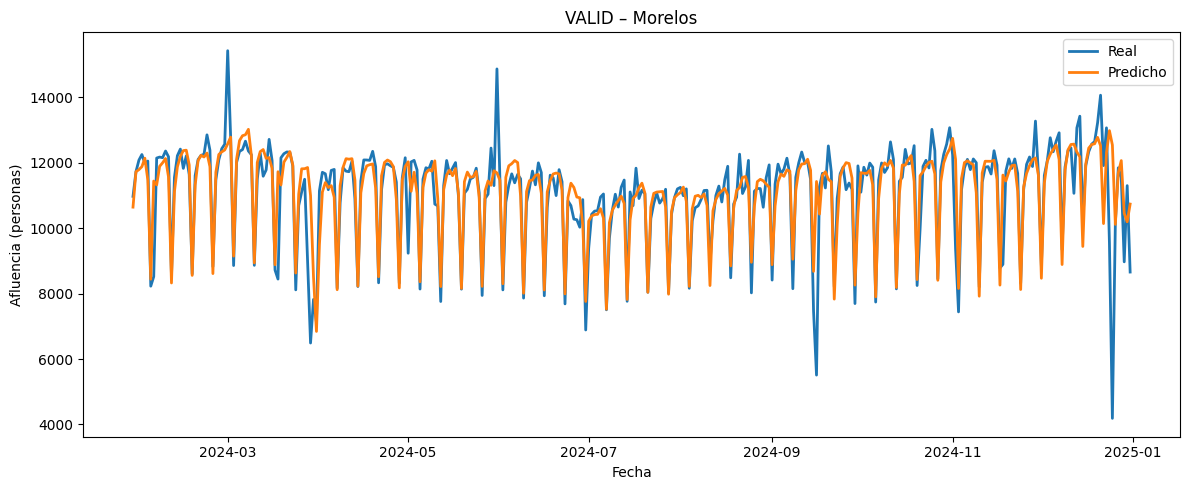

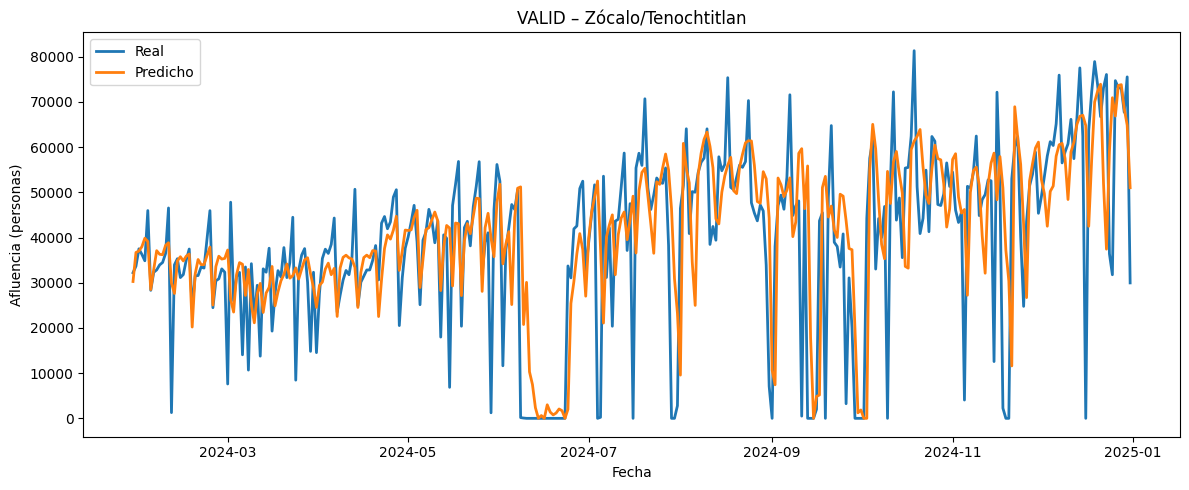

In [ ]:
def plot_station_predictions_fixed(estacion_name, 
                                   X_hist, X_est, X_dow, y_true, preds_scaled,
                                   part_df, title_prefix="VALID",
                                   lookback=LOOKBACK):
    """
    Plotea real vs predicho para una estación específica.
    - Alinea correctamente las fechas objetivo como fechas[LOOKBACK:].
    - Usa el orden en que se construyeron las ventanas (por estación y cronológico).
    """
    #filtrar índices de esta estación en los arrays de ventanas
    est_id = est2id[estacion_name]
    mask = (X_est.reshape(-1) == est_id)
    if mask.sum() == 0:
        print(f"No hay ventanas para la estación: {estacion_name} en {title_prefix}.")
        return

    #extraer series correspondientes a esta estación
    preds_scaled = np.maximum(preds_scaled.reshape(-1), 0)  # clamp
    y_true_est   = y_true[mask].reshape(-1)
    preds_est    = preds_scaled[mask]

    #fechas objetivo correctas = fechas[LOOKBACK:] para esa estación
    df_e = part_df[part_df['estacion'] == estacion_name].sort_values('fecha').reset_index(drop=True)
    fechas_obj = df_e['fecha'].iloc[lookback : lookback + len(y_true_est)].values
    if len(fechas_obj) != len(y_true_est):
        # por si hay alguna diferencia de bordes
        n = min(len(fechas_obj), len(y_true_est))
        fechas_obj = fechas_obj[:n]
        y_true_est = y_true_est[:n]
        preds_est  = preds_est[:n]

    #desescalar reales y predichos
    y_true_real = inverse_scale(estacion_name, y_true_est)
    y_pred_real = inverse_scale(estacion_name, preds_est)

    #gráfico
    plt.figure(figsize=(12,5))
    plt.plot(fechas_obj, y_true_real, label="Real", linewidth=2)
    plt.plot(fechas_obj, y_pred_real, label="Predicho", linewidth=2)
    plt.title(f"{title_prefix} – {estacion_name}")
    plt.xlabel("Fecha"); plt.ylabel("Afluencia (personas)")
    plt.legend()
    plt.tight_layout()
    plt.show()

# === EJEMPLOS ===
#valid
pred_va_scaled = model.predict([Xva_hist, Xva_est, Xva_dow], verbose=0)
plot_station_predictions_fixed("Morelos", Xva_hist, Xva_est, Xva_dow, yva, pred_va_scaled, valid_s, "VALID")
plot_station_predictions_fixed("Zócalo/Tenochtitlan", Xva_hist, Xva_est, Xva_dow, yva, pred_va_scaled, valid_s, "VALID")
